In [1]:
import torch 
import torch.nn as nn
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
d, w0 = 2, 20

In [31]:
x = np.linspace(0,1,500)
x_test=np.linspace(1,2,500)

In [32]:
x = np.array([x for _ in range(100)])
x_test= np.array([x_test for _ in range(100)])


(100, 500) (100, 500)


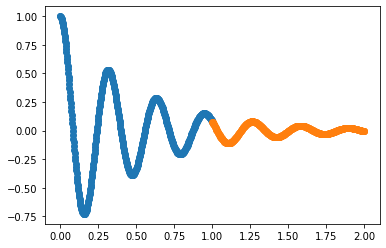

In [33]:

N = 100 # number of samples
y = oscillator(d, w0, x).astype(np.float32)
y_test =oscillator(d, w0, x_test).astype(np.float32)
print(x.shape,y.shape)
plt.scatter(x[1],y[1])
plt.scatter(x_test[1],y_test[1])

In [131]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [158]:
x = torch.linspace(0,1,500).requires_grad_()
x = x.repeat(100,1)
y = oscillator(d, w0, x)

In [159]:
y

tensor([[1.0000, 0.9992, 0.9968,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9992, 0.9968,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9992, 0.9968,  ..., 0.0884, 0.0838, 0.0791],
        ...,
        [1.0000, 0.9992, 0.9968,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9992, 0.9968,  ..., 0.0884, 0.0838, 0.0791],
        [1.0000, 0.9992, 0.9968,  ..., 0.0884, 0.0838, 0.0791]],
       grad_fn=<MulBackward0>)

In [142]:
#torch.diff(input,

In [160]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, outputs)
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=0.8)

        
        
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    


2 min 

In [185]:
class PhysicsInformedNN():
    
    def __init__(self):
        # deep neural networks
        self.dnn = LSTM()
        
        
    def net_u(self,t,future_preds=0):  
        u = self.dnn.forward(t, future_preds)
        return u
    
    def derivates(self, u ,coordinates):
        
        coordinates = (coordinates,)
        u_t = torch.gradient(u, spacing = coordinates)[0] 
        u_tt = torch.gradient(u, spacing = coordinates)[0] 

        return u_t , u_tt
    
    def net_f(self,t,lambda1=4.0,lambda2=400.0):
        """ The pytorch autograd version of calculating residual """

        u = self.net_u(t)
        
        u_t = torch.zeros(len(u),len(u[0]))
        u_tt = torch.zeros(len(u),len(u[0]))
        
        coordinate_t = torch.linspace(0,1,len(u[0]))
            
        for i , time_serie in enumerate(u): 
            u_t[i], u_tt[i] =  self.derivates(time_serie, t)
            
        f = u_tt + lambda1*u_t + lambda2*u
        return f , u , u_t , u_tt
    
    def predict(self, t,future_preds=0):
        self.dnn.eval()
        u = self.net_u(t,future_preds=0)
        return u 

In [186]:
model = PhysicsInformedNN()


In [ ]:

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
inpu = y[3:, :-1]
target =y[3:, 1:]
test_input = y[:3, :-1]
test_target = y[:3, 1:]
# build the model
seq = LSTM()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train

#begin to train

for i in range(10):
    print('STEP: ', i)
    def closure():
        
        seq.optimizer.zero_grad()
        out = seq(inpu)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    seq.optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 500
        pred = seq.forward(test_input, future_preds=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.scatter(, y[0], linewidth = 2.0)
    plt.scatter(x_test[1],y_test[1])
    #plt.savefig('plots_lstm/predict%d.jpg'%i)
    plt.show()
    plt.close()